<a href="https://colab.research.google.com/github/AgentschapPlantentuinMeise/DEMO_BioSpace25/blob/main/DEMO_BioSpace25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# B-Cubed DEMO BioSpace25
## Building data cubes



### Install missing packages

In [ ]:
%pip install pygbif
%pip install dask

### Only execute the following block when using the TPU kernel

In [ ]:
%pip install geopandas
%pip install pydrive
%pip install ee
%pip install eerepr
%pip install geemap

### Loading packages

In [1]:
from pygbif import occurrences as occ
import pandas as pd
import geopandas as gpd
from pyproj import Proj, Transformer
from shapely.geometry import mapping
from shapely.geometry import Polygon
import matplotlib.pyplot as plt


import io
from io import StringIO
import zipfile
import math

### Loading Earth Engine

In [ ]:
import geemap
import os

os.environ["ROADMAP"] = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}'
os.environ["SATELLITE"] = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}'
os.environ["TERRAIN"] = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}'
os.environ["HYBRID"] = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}'

Map = geemap.Map()
Map.add_basemap("HYBRID")
Map

In [ ]:
import ee

ee.Authenticate(force=True)
ee.Initialize(project='nithecs-436810')

LANDSAT_ID = "LANDSAT/LC08/C02/T1_L2"
BOUNDARIES_ID = 'FAO/GAUL/2015/level1'
WDPA_ID = 'WCMC/WDPA/current/polygons'
SENTINEL_ID = "COPERNICUS/S2_SR_HARMONIZED"


dataset = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2').filterDate('2021-05-01', '2021-06-01')
sa = ee.FeatureCollection(BOUNDARIES_ID).filter(
    'ADM0_NAME == "South Africa"')

dataset_eo = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED').filterDate('2020-01-01', '2020-01-30')

protected_areas = ee.FeatureCollection(WDPA_ID)


sa_landsat = dataset.filterBounds(sa)
sa_sentinel = dataset_eo.filterBounds(sa)


### Example of the GBIF API through pygbif

In [4]:
from pygbif import occurrences
data = occurrences.search(speciesKey=5229490, limit=10)

print(data['results'])

[{'key': 5011069995, 'datasetKey': 'ba19fc1d-670c-426b-b99d-49f003792ac4', 'publishingOrgKey': 'f5fc4e61-b7a0-414b-ab68-b41cb23e7fdc', 'installationKey': 'd973e647-8f5f-4e6e-a1c6-65930deb0590', 'hostingOrganizationKey': 'f5fc4e61-b7a0-414b-ab68-b41cb23e7fdc', 'publishingCountry': 'RU', 'protocol': 'DWC_ARCHIVE', 'lastCrawled': '2025-01-22T20:14:44.646+00:00', 'lastParsed': '2025-01-22T20:38:27.131+00:00', 'crawlId': 303, 'projectId': 'N-Eurasia-Russia2021', 'programmeAcronym': 'N-Eurasia', 'extensions': {}, 'basisOfRecord': 'MACHINE_OBSERVATION', 'individualCount': 1, 'occurrenceStatus': 'PRESENT', 'taxonKey': 5229490, 'kingdomKey': 1, 'phylumKey': 44, 'classKey': 212, 'orderKey': 729, 'familyKey': 5235, 'genusKey': 7237083, 'speciesKey': 5229490, 'acceptedTaxonKey': 5229490, 'scientificName': 'Pica pica (Linnaeus, 1758)', 'acceptedScientificName': 'Pica pica (Linnaeus, 1758)', 'kingdom': 'Animalia', 'phylum': 'Chordata', 'order': 'Passeriformes', 'family': 'Corvidae', 'genus': 'Pica',

## GBIF data Cubes

### Generating the Cube

#### Exemplar JSON query for generating a data cube


```
# DON'T EXECUTE THIS CELL. FOR DEMO PUPOSE ONLY #
{
  "sendNotification": true,
  "notificationAddresses": [
    "maarten.trekels@plantentuinmeise.be"
  ],
  "format": "SQL_TSV_ZIP",
  "sql": "SELECT  PRINTF('%04d-%02d', \"year\", \"month\") AS yearMonth,
   GBIF_EEARGCode(10000, decimalLatitude,  decimalLongitude,  COALESCE(coordinateUncertaintyInMeters, 1000) ) AS eeaCellCode,
   speciesKey,
   species,
   establishmentMeans,
   degreeOfEstablishment,
   pathway,
   COUNT(*) AS occurrences,
   COUNT(DISTINCT recordedBy) AS distinctObservers
   FROM  occurrence
   WHERE occurrenceStatus = 'PRESENT'
   AND countryCode = 'BE'
   AND hasCoordinate = TRUE
   AND NOT ARRAY_CONTAINS(issue, 'ZERO_COORDINATE')
   AND NOT ARRAY_CONTAINS(issue, 'COORDINATE_OUT_OF_RANGE')
   AND NOT ARRAY_CONTAINS(issue, 'COORDINATE_INVALID')
   AND NOT ARRAY_CONTAINS(issue, 'COUNTRY_COORDINATE_MISMATCH')
   AND \"month\" IS NOT NULL
   GROUP BY yearMonth,
   eeaCellCode,
   speciesKey,
   species,
   establishmentMeans,
   degreeOfEstablishment,
   pathway
   ORDER BY  yearMonth DESC,
   eeaCellCode ASC,
   speciesKey ASC"
}


```



## Loading the Data cube in pandas



You can download a pre generated data cube from GitHub or any other online resource

#### Get data from Drive

In [2]:
def convert_to_int(x):
       try:
           return int(x)
       except ValueError:
           return pd.NA  # or np.nan if you prefer NumPy NaNs

data = pd.read_csv('./DEMO_BioSpace25_files/Cube_ZA_QDGC_l3.csv', sep='\t', converters={'familykey': convert_to_int, 'specieskey': convert_to_int})

data['familykey'] = pd.to_numeric(data['familykey'], errors='coerce').astype('Int64')
data['specieskey'] = pd.to_numeric(data['specieskey'], errors='coerce').astype('Int64')


In [ ]:
print(data)

## Getting a Geopackage file from the Grid that you use

In [3]:
# Load QDGC code

input_file = "./DEMO_BioSpace25_files/qdgc_south_africa.gpkg"

qdgc_ref = gpd.read_file(input_file, layer='tbl_qdgc_03')

In [ ]:
print(qdgc_ref)

## Merging the Data cube with the grid

In [4]:
test_merge = pd.merge(data, qdgc_ref, left_on='qdgccode', right_on='qdgc')

In [5]:
# Convert to GeoDataFrame

gdf = gpd.GeoDataFrame(test_merge, geometry='geometry')

gdf = gdf.set_crs(epsg=4326, inplace=False)

## Filtering data (e.g. on species)
Check for a single species (Loxodonta africana: https://www.gbif.org/species/2435350)

In [6]:
filtered_gdf = gdf[gdf['specieskey'].eq(2435350)]

print(filtered_gdf)


         yearmonth    qdgccode  familykey        family  specieskey  \
6401       2024-09  E025S33BAD       9427  Elephantidae     2435350   
6402       2024-09  E025S33BBC       9427  Elephantidae     2435350   
6403       2024-09  E025S33BCA       9427  Elephantidae     2435350   
6405       2024-09  E025S33BCB       9427  Elephantidae     2435350   
6406       2024-09  E025S33BCC       9427  Elephantidae     2435350   
...            ...         ...        ...           ...         ...   
14708306   1990-01  E025S33BCB       9427  Elephantidae     2435350   
14708309   1990-01  E025S33BDA       9427  Elephantidae     2435350   
16222304   1987-01  E031S24BBC       9427  Elephantidae     2435350   
16427602   1985-09  E031S23ABA       9427  Elephantidae     2435350   
16427611   1985-09  E031S23ADD       9427  Elephantidae     2435350   

                     species  occurrences  familycount        qdgc  \
6401      Loxodonta africana           14       5301.0  E025S33BAD   
6402   

In [7]:
del gdf

In [8]:
del test_merge

In [9]:
del data

## Apply the function to create a list of features in GEE

In [ ]:
filtered_gdf = filtered_gdf.set_crs(epsg=4326, inplace=False)

data_raw = geemap.geopandas_to_ee(filtered_gdf)

## Visualization of the data cubes on a map with different layers

In [18]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
import rioxarray
import planetary_computer


# 2. Get Sentinel-2 data from Planetary Computer
bbox_total = filtered_gdf.total_bounds
bbox = [30.9, -25.5, 32.0, -22.0] #Kruger bbox

aoi = {
    "type": "Polygon",
    "coordinates": [[
        [bbox[0], bbox[1]],
        [bbox[2], bbox[1]],
        [bbox[2], bbox[3]],
        [bbox[0], bbox[3]],
        [bbox[0], bbox[1]],
    ]],
}

catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=planetary_computer.sign_inplace)


items = catalog.search(
    bbox=bbox,
    datetime="2013-06-01/2024-11-19",  # Adjust date range as needed 11/18/2024
    query={"eo:cloud_cover": {"lt": 10}},  # Adjust cloud cover as needed
    collections=["sentinel-2-l2a"],
).items()

least_cloudy_item = min(items, key=lambda item: eo.ext(item).cloud_cover)

print(
    f"Choosing {least_cloudy_item.id} from {least_cloudy_item.datetime.date()}"
    f" with {eo.ext(least_cloudy_item).cloud_cover}% cloud cover"
)

# 3. Read the Raster Data
asset = least_cloudy_item.assets["visual"]
print(asset.href)

raster_data = rioxarray.open_rasterio(asset.href, masked=True)

# Check min and max values
min_val, max_val = raster_data.min().item(), raster_data.max().item()

# Normalize data if in 0-255 range
if max_val > 1:
    raster_data = raster_data / 255.0  # Convert to 0-1 range

# Ensure the CRS is properly set
filtered_gdf = filtered_gdf.to_crs("EPSG:3857")
raster_data = raster_data.rio.reproject("EPSG:3857")

# 5. Plot the Data
fig, ax = plt.subplots(figsize=(20, 16))

# Plot the Sentinel-2 image
raster_data.plot.imshow(
    ax=ax, extent=[bbox[0], bbox[2], bbox[1], bbox[3]], cmap="viridis", alpha=0.7
)
'''
raster_data = raster_data.transpose("y", "x", "band")  # Ensure correct shape
ax.imshow(raster_data, extent=[bbox[0], bbox[2], bbox[1], bbox[3]])
'''

# Plot the GeoDataFrame
filtered_gdf.plot(ax=ax, color="red", edgecolor="black", linewidth=1, alpha=0.5)

# Adjust Axes
ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs="EPSG:3857")


# Labels and Title
plt.title("GeoPandas DataFrame on Sentinel-2 Background")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the Plot
plt.show()

Choosing S2A_MSIL2A_20241118T074211_R092_T36KTA_20241118T115551 from 2024-11-18 with 0.0% cloud cover
https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/36/K/TA/2024/11/18/S2A_MSIL2A_20241118T074211_N0511_R092_T36KTA_20241118T115551.SAFE/GRANULE/L2A_T36KTA_A049138_20241118T075516/IMG_DATA/R10m/T36KTA_20241118T074211_TCI_10m.tif?st=2025-02-09T22%3A41%3A53Z&se=2025-02-10T23%3A26%3A53Z&sp=rl&sv=2024-05-04&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2025-02-10T04%3A13%3A00Z&ske=2025-02-17T04%3A13%3A00Z&sks=b&skv=2024-05-04&sig=LETrpMsofST%2Bbx4BCufs3BL1U4dNfvtRu2gVjxac0gs%3D


: 

/home/maarten/.local/lib/python3.11/site-packages/matplotlib/cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


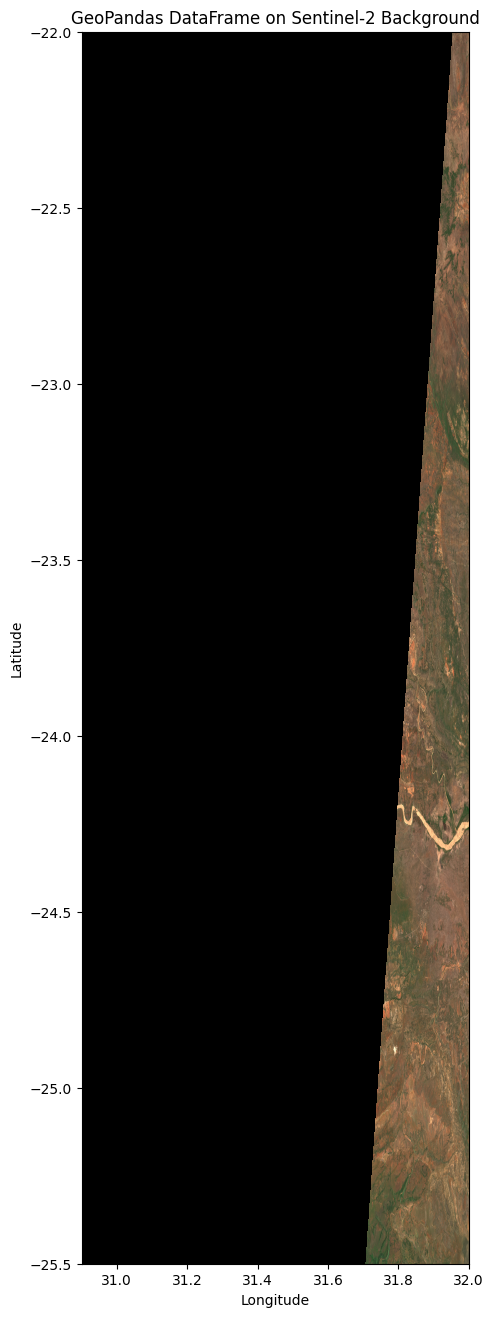

In [ ]:
# 5. Plot the Data
fig, ax = plt.subplots(figsize=(20, 16))

'''
# Plot the Sentinel-2 image
raster_data.plot.imshow(
    ax=ax, extent=[bbox[0], bbox[2], bbox[1], bbox[3]], cmap="viridis", alpha=0.7
)
'''

filtered_gdf = filtered_gdf.to_crs("EPSG:3857")
raster_data = raster_data.rio.reproject("EPSG:3857")

raster_data = raster_data.transpose("y", "x", "band")  # Ensure correct shape
ax.imshow(raster_data, extent=[bbox[0], bbox[2], bbox[1], bbox[3]])


# Plot the GeoDataFrame
# Ensure the CRS is properly set

filtered_gdf.plot(ax=ax, color="red", edgecolor="black", linewidth=1, alpha=0.4)

# Adjust Axes
ax.set_xlim(bbox[0], bbox[2])
ax.set_ylim(bbox[1], bbox[3])

# Add Basemap
# ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=filtered_gdf.crs)

# Labels and Title
plt.title("GeoPandas DataFrame on Sentinel-2 Background")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# Show the Plot
plt.show()

In [18]:
print(f"NaN count in raster: {np.isnan(raster_data.values).sum()}")
print(f"Raster min: {raster_data.values.min()}, max: {raster_data.values.max()}")

NaN count in raster: 244206416
Raster min: nan, max: nan


In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
Map = geemap.Map(layout={"height": "400px", "width": "800px"})


# Add the original data layer in blue
Map.addLayer(data_raw, {"color": "blue"}, "Original data")

visualization = {
    'min': 0.0,
    'max': 0.3,
    'bands': ['B2', 'B3', 'B4'],
}

Map.addLayer(sa_sentinel, visualization, 'RGB')

Map.addLayer(protected_areas)


# Set the center of the map to the coordinates
Map.setCenter(-28.50, 29.41)
Map

## Export the data to GeoParquet

In [ ]:
#gdf.to_parquet('/content/drive/Shareddrives/BioSpace25/supporting_data/data_ZA.parquet')

# EBV data cubes in NetCDF format

In [1]:
%pip install netCDF4

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install rioxarray
%pip install cartopy
%pip install basemap

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 3.3 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 942.4/942.4 kB 2.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 10.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 21.7 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0

In [3]:
import netCDF4 as nc
import xarray as xr


birds_file = xr.open_dataset('./DEMO_BioSpace25_files/viti_spepop_id77_20240206_v1.nc')

print(birds_file)

<xarray.Dataset> Size: 26kB
Dimensions:  (lon: 559, lat: 437, time: 1, entity: 486)
Coordinates:
  * lon      (lon) float64 4kB 9.45e+05 9.55e+05 ... 6.515e+06 6.525e+06
  * lat      (lat) float64 3kB 5.305e+06 5.295e+06 ... 9.55e+05 9.45e+05
  * time     (time) datetime64[ns] 8B 2018-01-01
  * entity   (entity) |S37 18kB b'Gavia stellata                       ' ... ...
Data variables:
    crs      |S1 1B ...
Attributes: (12/38)
    Conventions:                CF-1.8, ACDD-1.3, EBV-1.0
    naming_authority:           The German Centre for Integrative Biodiversit...
    history:                    EBV netCDF created using ebvcube, 2024-02-06
    ebv_vocabulary:             https://portal.geobon.org/api/v1/ebv
    ebv_cube_dimensions:        lon, lat, time, entity
    keywords:                   ebv_class: Species populations, ebv_name: Spe...
    ...                         ...
    geospatial_lat_units:       meter
    time_coverage_start:        2013-01-01
    time_coverage_end:       

In [6]:
def print_netcdf_structure(nc_file_path):
  """Prints the structure (groups, variables, and their paths) of a NetCDF file.

  Args:
    nc_file_path: Path to the NetCDF file.
  """
  def print_group_structure(group, path=""):
    """Recursively prints the structure of a group within the NetCDF file."""
    for var_name in group.variables:
      print(f"{path}/{var_name}")  # Print variable path
    for group_name in group.groups:
      subgroup = group.groups[group_name]
      print_group_structure(subgroup, f"{path}/{group_name}")  # Recursively explore subgroups

  with nc.Dataset(nc_file_path, 'r') as nc_file:
    print_group_structure(nc_file)  # Start with the root group

# Example usage:
nc_file_path = './DEMO_BioSpace25_files/viti_spepop_id77_20240206_v1.nc'
print_netcdf_structure(nc_file_path)

/lon
/lat
/time
/crs
/entity
/metric_1/ebv_cube


In [7]:
print(birds_file.variables)

Frozen({'lon': <xarray.IndexVariable 'lon' (lon: 559)> Size: 4kB
array([ 945000.,  955000.,  965000., ..., 6505000., 6515000., 6525000.])
Attributes:
    long_name:      lon
    standard_name:  projection_x_coordinate
    axis:           X
    units:          meter, 'lat': <xarray.IndexVariable 'lat' (lat: 437)> Size: 3kB
array([5305000., 5295000., 5285000., ...,  965000.,  955000.,  945000.])
Attributes:
    long_name:      lat
    standard_name:  projection_y_coordinate
    axis:           Y
    units:          meter, 'time': <xarray.IndexVariable 'time' (time: 1)> Size: 8B
array(['2018-01-01T00:00:00.000000000'], dtype='datetime64[ns]')
Attributes:
    long_name:  time
    axis:       T, 'crs': <xarray.Variable ()> Size: 1B
[1 values with dtype=|S1]
Attributes:
    spatial_ref:                     PROJCRS["ETRS89-extended / LAEA Europe",...
    GeoTransform:                    940000 10000 0.0 5310000 0.0 -10000
    grid_mapping_name:               lambert_azimuthal_equal_area
    l

In [8]:
time = birds_file.variables['time']
print(time)

print(birds_file['entity'])

<xarray.IndexVariable 'time' (time: 1)> Size: 8B
array(['2018-01-01T00:00:00.000000000'], dtype='datetime64[ns]')
Attributes:
    long_name:  time
    axis:       T
<xarray.DataArray 'entity' (entity: 486)> Size: 18kB
array([b'Gavia stellata                       ',
       b'Gavia arctica                        ',
       b'Tachybaptus ruficollis               ', ...,
       b'Accipiter gentilis all others        ',
       b'Melanitta nigra s. str.              ',
       b'Sylvia subalpina                     '], dtype='|S37')
Coordinates:
  * entity   (entity) |S37 18kB b'Gavia stellata                       ' ... ...
Attributes:
    units:                           1
    ebv_entity_type:                 Species
    ebv_entity_scope:                Bird species listed under the Art. 12 of...
    ebv_entity_classification_name:  Species names as accepted by the Birds D...
    ebv_entity_classification_url:   https://cdr.eionet.europa.eu/help/birds_...
    long_name:                     

/home/maarten/.local/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/home/maarten/.local/lib/python3.11/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


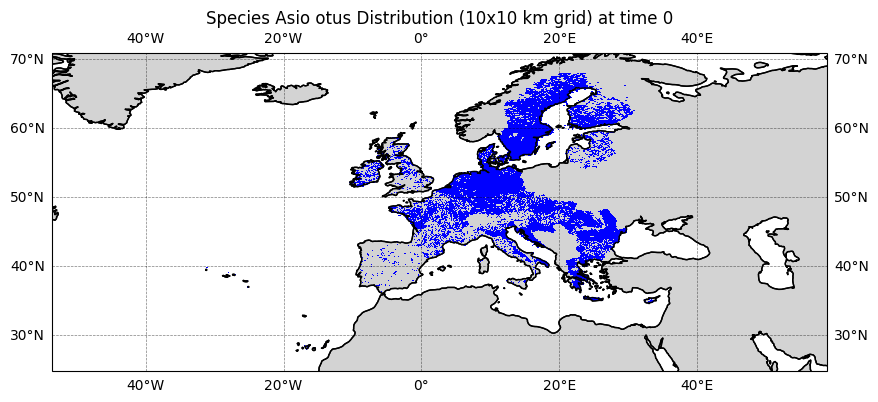

In [10]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import xarray as xr
import numpy as np
from pyproj import Transformer
from matplotlib.colors import ListedColormap, BoundaryNorm

# --- Load Dataset Efficiently ---
birds_file = xr.open_dataset(
    './DEMO_BioSpace25_files/viti_spepop_id77_20240206_v1.nc',
    group="metric_1",
    chunks={'entity': 1, 'time': 1}  # Load only one entity/time slice at a time
)

# --- Select Target Species and Time ---
species_index = 150  # Change to the species index you need
time_index = 0  # Change to the desired time index

# Extract only the required slice
species_data_subset = birds_file['ebv_cube'].sel(entity=species_index, time=time_index).compute()

# Convert to a 2D array
species_distribution_2d = np.squeeze(species_data_subset)

# --- Load Longitude and Latitude (Only Once) ---
with xr.open_dataset('./DEMO_BioSpace25_files/viti_spepop_id77_20240206_v1.nc') as ds:
    lon = ds['lon'].values  # 1D array (size: 559)
    lat = ds['lat'].values  # 1D array (size: 437)

# --- Create Meshgrid Efficiently ---
lon_grid, lat_grid = np.meshgrid(lon, lat)

# --- Efficient Coordinate Transformation ---
transformer = Transformer.from_crs("epsg:3035", "epsg:4326", always_xy=True)

# Transform the entire 2D meshgrid
lon_deg, lat_deg = transformer.transform(lon_grid, lat_grid)

# --- Create the Plot ---
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add map features
ax.coastlines()
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')

# --- 🔹 Fix: Use Discrete Colormap Without Color Bar ---
unique_values = np.unique(species_distribution_2d)

# If only one value, choose a single solid color
if len(unique_values) == 1:
    cmap = ListedColormap(["red"])  # Single-color for uniform data
    norm = None
else:
    cmap = ListedColormap(["white", "blue"])  # Adjust colors as needed
    norm = BoundaryNorm([0, 0.5, 1], cmap.N)

# --- 🔹 Fix: Use `shading="nearest"` to Ensure Correct Grid Alignment ---
cs = ax.pcolormesh(
    lon_deg, lat_deg, species_distribution_2d,
    transform=ccrs.PlateCarree(),
    cmap=cmap,
    norm=norm,
    shading='nearest'  # Prevents visual distortion
)

# --- 🔹 Completely Remove Color Bar ---
# No `fig.colorbar(cs)`, so no scale bar will be shown

# --- Get the Species Name Efficiently ---
with xr.open_dataset('./DEMO_BioSpace25_files/viti_spepop_id77_20240206_v1.nc') as ds:
    species_name = ds['entity'].values[species_index].decode('utf-8').strip()

# --- Final Plot Customization ---
ax.set_title(f"Species {species_name} Distribution (10x10 km grid) at time {birds_file['time'].values[time_index].item()}")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# --- 🔹 Fix: Add Grid Lines to Show Exact 10x10 km Cells ---
gridlines = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="black", alpha=0.5)

# Show the plot
plt.show()


In [ ]:
from google.colab import output
output.disable_custom_widget_manager()